# Data Windowing
* This notebook contains a class that allows us to format the data appropriatly to feed to the deep learning models.
* We also have a plotting method in this class that helps us to visualize the predictions and the actual values.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
import datetime

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

## Data Window Class

* Width of the input -> the number of timesteps that are fed into the model for predictions (if we feed the model with 24hrs data then the input width is 24).
* Label width -> the number of timestemps that we are predicting (if we predict a full day of hourly data then the label width will be 24).
* Shift -> the number of timestamps separating the input and the predictions (if we predict the next 24hrs using the previous 24hrs then the shift is 24).
* Window size -> It is the sum of the width of the input and the label width. 

For our data, 
* Width of the input = 24
* Label width = 24
* Shift = 24
* Window size = 48

In [3]:
train_df = pd.read_csv('data/train.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)
val_df = pd.read_csv('data/val.csv', index_col=0)

train_df.shape, val_df.shape, test_df.shape

((12285, 5), (3510, 5), (1756, 5))

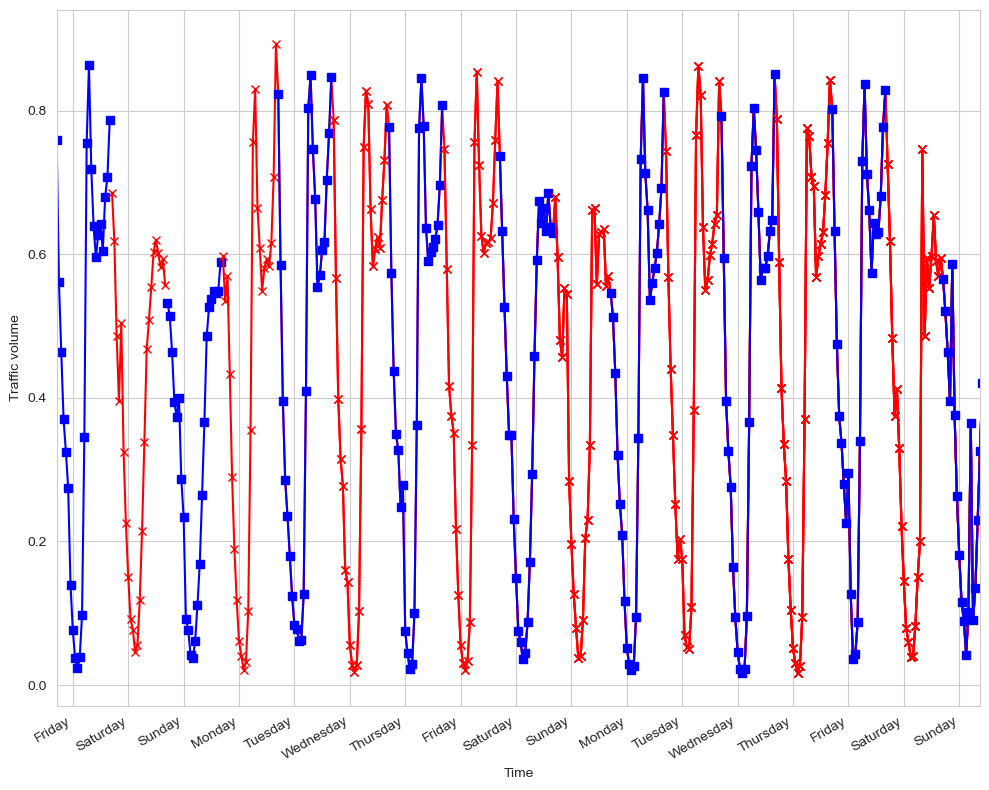

In [4]:
fig = plt.figure(figsize=(10, 8))

for n in range(0, 17, 2):
    start = 24 * n
    stop = 24 * (n + 1)
    plt.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    plt.plot(train_df.traffic_volume[stop:stop*2], marker='x', color='red', label='label')

plt.xlabel('Time')
plt.ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
                                   'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

* We can visualize the parameters that we have set by plotting the first 400 points above.
* s(blue) - input, x(red) - labels

In [5]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns #name of the column that we wish to predict
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} #dict with the name and index of the label column, this will be used for plotting
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} #dict with the name and index of each column, this will be used to separate the features form the target variable
        
        self.input_width = input_width 
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        #inputs
        self.input_slice = slice(0, input_width) #specifies how to slice the sequence, here it starts at 0 and ends when we reach the input_width
        self.input_indices = np.arange(self.total_window_size)[self.input_slice] #assigns indices to the inputs, these are useful for plotting
        
        #labels
        self.label_start = self.total_window_size - self.label_width #the index in which the labels start
        self.labels_slice = slice(self.label_start, None) #the same steps that were used for inputs are applied for the labels as well
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    #method splitting the window between the inputs and the labels
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :] #slice the window to get the inputs using the input_slice in __init__
        labels = features[:, self.labels_slice, :] #slice the window to get the labels using the labels_slice in __init__
        if self.label_columns is not None: #if we have more than one target, we stack the variables
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None]) #the shape will be [batch, time, features], we only define the time here and the rest will be defind later on
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    #method to plot the input data, the predictions and the actual values (we are plotting only for 3 windows and plot the traffic volume by default, but this can be changed easily)
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10) #plotting the inputs (continuous blue line with dots)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64) #plot the labels/actual values (green squares)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64) #plot the preedictions (red crosses)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    #format the dataset into tensors
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size, #define length of array = window size
            sequence_stride=1, #number of timesteps separating each sequence, here we want consecutive sequences so=1
            shuffle=True, #shuffling the sequences in a single batch
            batch_size=32 #number of sequences in a single batchx
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## Applying Baseline models

* Baseline models are used as a bechmark to evaluate more complex models.

### Single-step baseline model

* Input is one timestamp and the output is the prediction of the next timestep.
* input width = 1
* label width = 1
* shift = 1
* target variable = volume of traffic

In [7]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])

* We also define a wider window so we can visualize many predictions of out model.

In [8]:
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

* The simplest prediction we can make is the last observed value.
* We implement this by the Baseline class.

In [9]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [10]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['traffic_volume'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [11]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 2s 5ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


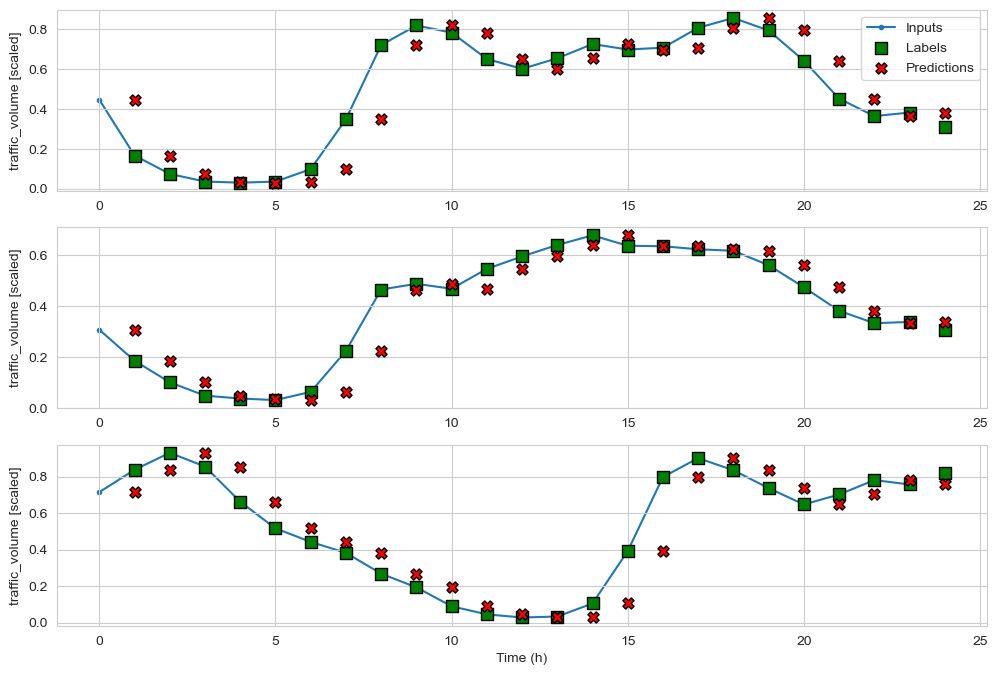

In [12]:
wide_window.plot(baseline_last)

In [13]:
print(performance['Baseline - Last'][1])

0.08128400146961212


### Multi-step baseline model

* We are predicting more than one timestamp into the future.
* Here we are forcasting traffic volume for the next 24 hours.

In [14]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

* Predicting the last known value for the next 24 timesteps.

In [15]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [16]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 5ms/step - loss: 0.1887 - mean_absolute_error: 0.3534


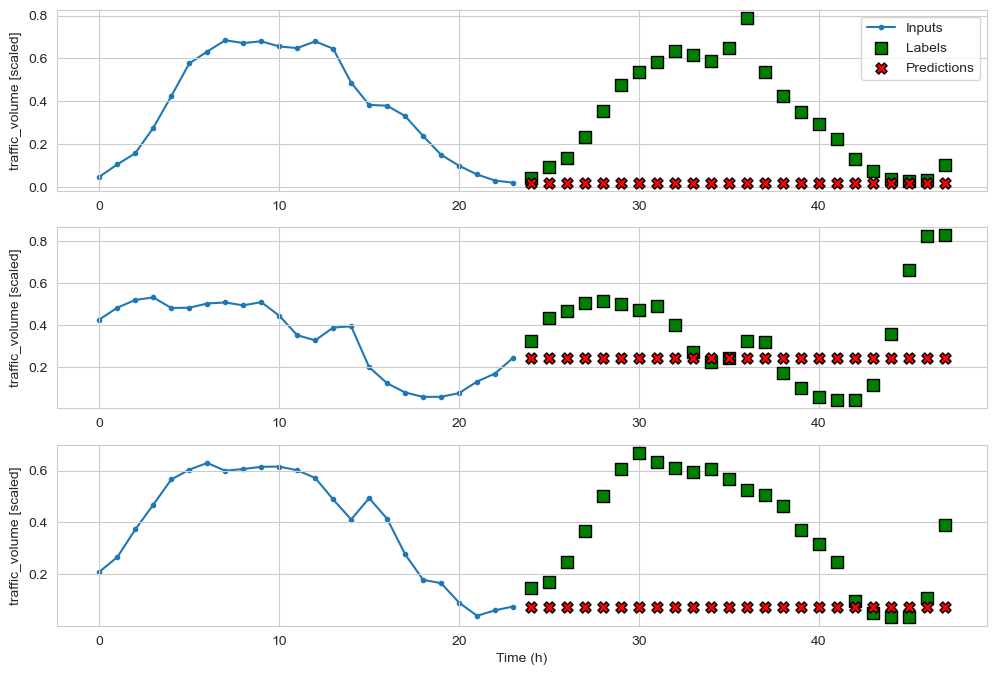

In [17]:
multi_window.plot(ms_baseline_last)

In [18]:
print(ms_performance['Baseline - Last'][1])

0.3483619689941406


* Predicting the last 24 timestamps for the next 24 timestamps.

In [19]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [20]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 4ms/step - loss: 0.1216 - mean_absolute_error: 0.2469


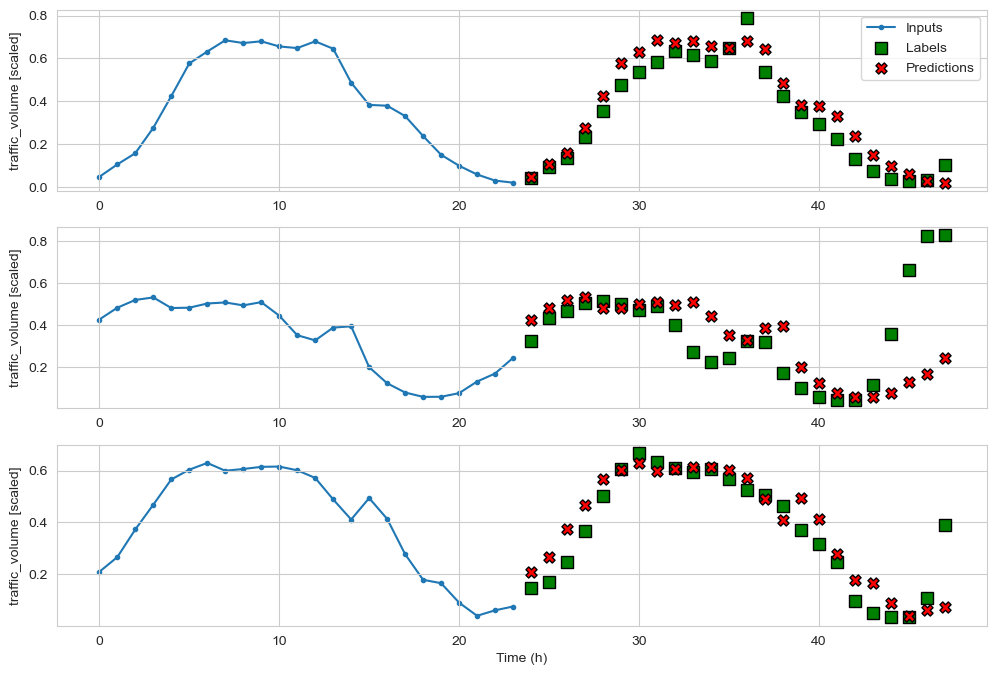

In [21]:
multi_window.plot(ms_baseline_repeat)

In [22]:
print(ms_performance['Baseline - Repeat'][1])

0.23835381865501404


### Multi-output model

* We predict more than one variable.

In [23]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [24]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [25]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 1s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0482


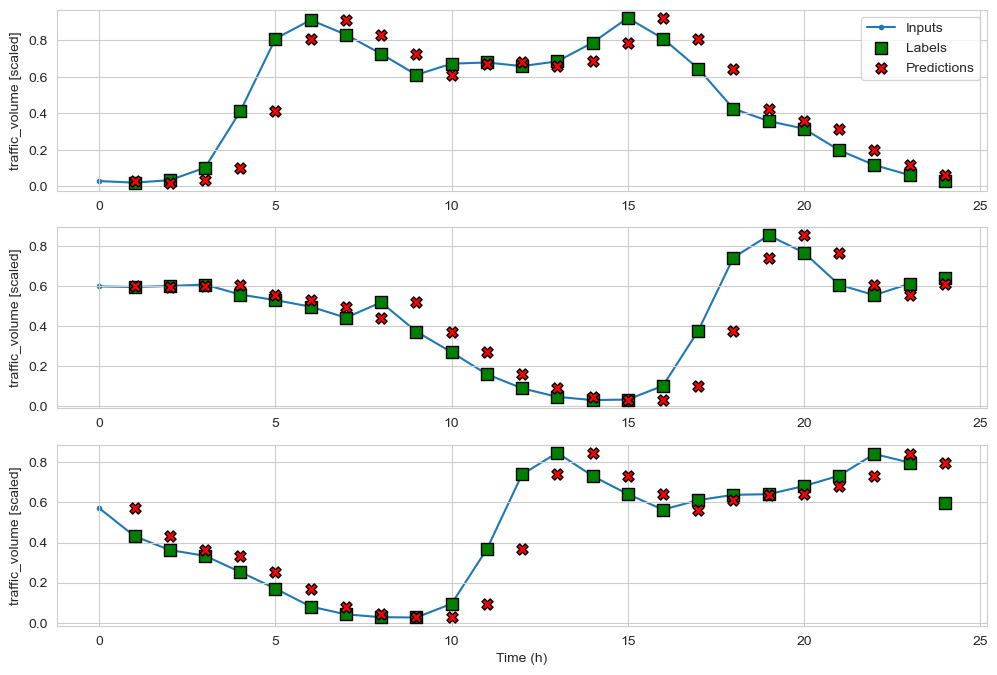

In [26]:
mo_wide_window.plot(mo_baseline_last)

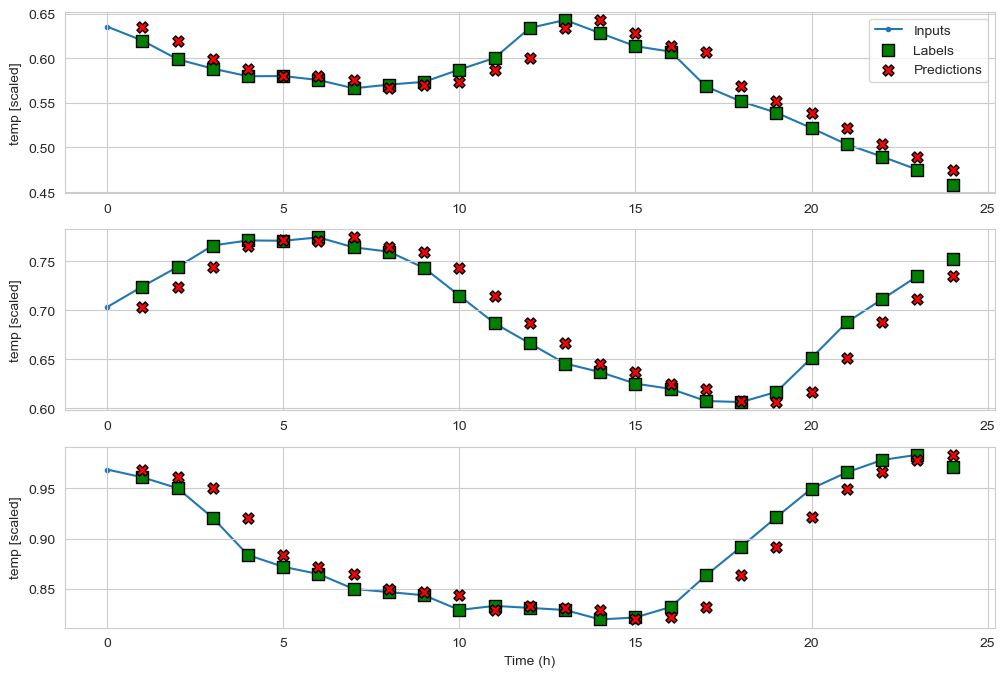

In [27]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

In [28]:
print(mo_performance['Baseline - Last'][1])

0.04710666462779045


## Implemeting a Linear Model

* The models has one input layer, one ouput layer and no hidden uunits.
* Each input feature is given a weight and they arecombined to produce the output prediction.
* Our dataset has 5 input features.
* So the model assigns a weight to each of the features.
* The model then tries different values for the weights in order to minimize the mean squared error (MSE) between the predictions and actual values of the traffic volume.

### Single-Step linear model

* sigle_step_window -> training
* wide_window -> plotting

In [29]:
#function takes a model and window of data from the DataWindow class. patience - the number of epochs after which the model should stop training if the validation loss does not improve
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss', #validation loss is tracked to determine if we should apply early stopping or not
                                   patience=patience, #early stopping occurs if 3 consecutive epochs do not decrease the validation loss
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(), #MSE is used as the loss function
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()]) #MAE is used as an error mertric
    
    history = model.fit(window.train, #the model is fit on the training set
                       epochs=max_epochs, #the model can train atmost 50 epochs
                       validation_data=window.val, #validation set is used to calculate the validation loss
                       callbacks=[early_stopping]) #early_stopping is passed as the callback
    
    return history

In [30]:
linear = Sequential([
    Dense(units=1)
])

In [31]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/50
384/384 [==============================] - 7s 10ms/step - loss: 0.2860 - mean_absolute_error: 0.4287 - val_loss: 0.1653 - val_mean_absolute_error: 0.3365
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.1024 - mean_absolute_error: 0.2560 - val_loss: 0.0644 - val_mean_absolute_error: 0.2095
Epoch 3/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0426 - mean_absolute_error: 0.1650 - val_loss: 0.0318 - val_mean_absolute_error: 0.1465
Epoch 4/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0240 - mean_absolute_error: 0.1226 - val_loss: 0.0210 - val_mean_absolute_error: 0.1166
Epoch 5/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0173 - mean_absolute_error: 0.1021 - val_loss: 0.0159 - val_mean_absolute_error: 0.0994
Epoch 6/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0138 - mean_absolute_error: 0.0893 - val_loss: 0.0128 - val_mean_absolute_error: 0.0875
Epoch 7/50
384/

In [32]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 1s 7ms/step - loss: 0.0090 - mean_absolute_error: 0.0658


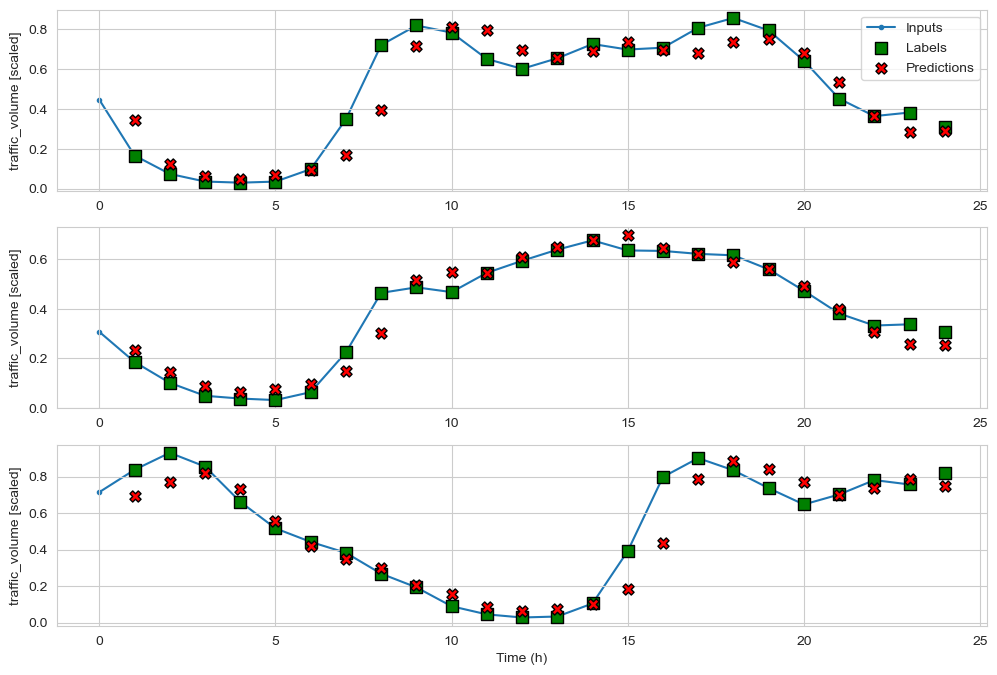

In [34]:
wide_window.plot(linear)

### Multi-step linear model

* We will slightly modify the single-step model to generate the multi-step model.
* The model will take 24hrs of input for each of the input features (5).
* The model will then output the forcast for the next 24hrs.
* We will additionally set the inital weight values as 0.

In [35]:
ms_linear = Sequential([
    Dense(1, kernel_initializer = tf.initializers.zeros)
])

In [36]:
history = compile_and_fit(ms_linear, multi_window)

Epoch 1/50
383/383 [==============================] - 3s 6ms/step - loss: 0.0764 - mean_absolute_error: 0.2216 - val_loss: 0.0367 - val_mean_absolute_error: 0.1572
Epoch 2/50
383/383 [==============================] - 3s 8ms/step - loss: 0.0257 - mean_absolute_error: 0.1271 - val_loss: 0.0230 - val_mean_absolute_error: 0.1178
Epoch 3/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0186 - mean_absolute_error: 0.1025 - val_loss: 0.0199 - val_mean_absolute_error: 0.1041
Epoch 4/50
383/383 [==============================] - 2s 5ms/step - loss: 0.0172 - mean_absolute_error: 0.0953 - val_loss: 0.0190 - val_mean_absolute_error: 0.0990
Epoch 5/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0168 - mean_absolute_error: 0.0924 - val_loss: 0.0186 - val_mean_absolute_error: 0.0960
Epoch 6/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0165 - mean_absolute_error: 0.0904 - val_loss: 0.0183 - val_mean_absolute_error: 0.0941
Epoch 7/50
383/3

In [37]:
ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 6ms/step - loss: 0.0180 - mean_absolute_error: 0.0886


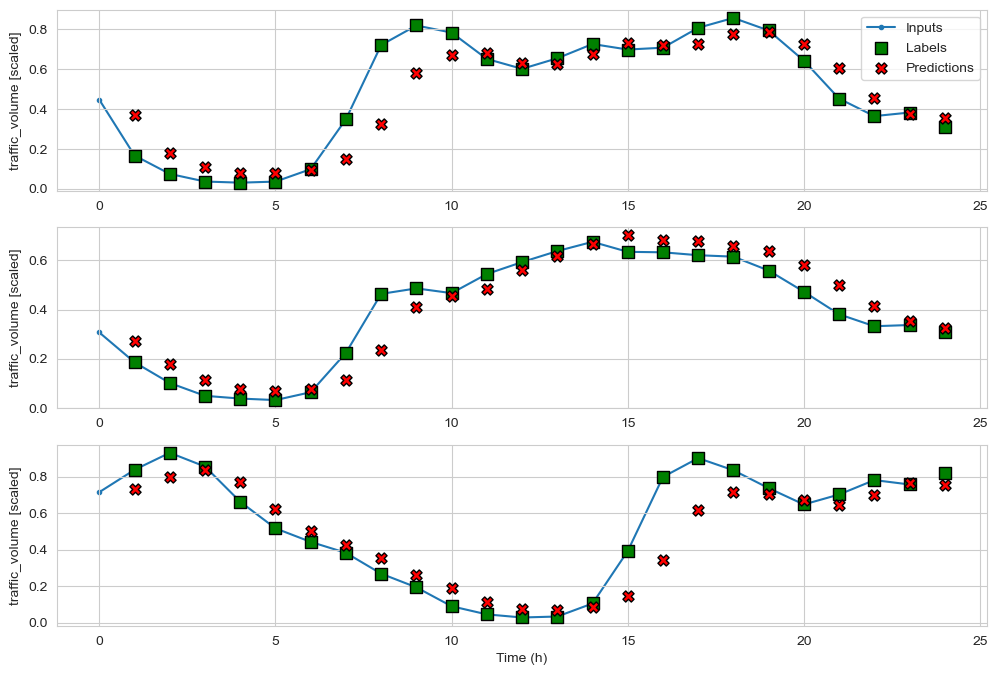

In [40]:
wide_window.plot(ms_linear)

### Multi-output linear model

* For this model we will predict the traffic volume as well as the temperature.

In [41]:
mo_linear = Sequential([
    Dense(units=2)
])

In [42]:
history = compile_and_fit(mo_linear, mo_single_step_window)

Epoch 1/50
384/384 [==============================] - 4s 6ms/step - loss: 0.3865 - mean_absolute_error: 0.5017 - val_loss: 0.1905 - val_mean_absolute_error: 0.3646
Epoch 2/50
384/384 [==============================] - 2s 6ms/step - loss: 0.1264 - mean_absolute_error: 0.2915 - val_loss: 0.0856 - val_mean_absolute_error: 0.2424
Epoch 3/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0580 - mean_absolute_error: 0.1973 - val_loss: 0.0394 - val_mean_absolute_error: 0.1649
Epoch 4/50
384/384 [==============================] - 3s 8ms/step - loss: 0.0276 - mean_absolute_error: 0.1358 - val_loss: 0.0199 - val_mean_absolute_error: 0.1151
Epoch 5/50
384/384 [==============================] - 3s 8ms/step - loss: 0.0151 - mean_absolute_error: 0.0992 - val_loss: 0.0120 - val_mean_absolute_error: 0.0863
Epoch 6/50
384/384 [==============================] - 4s 9ms/step - loss: 0.0101 - mean_absolute_error: 0.0784 - val_loss: 0.0088 - val_mean_absolute_error: 0.0698
Epoch 7/50
384/3

In [43]:
mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

110/110 [==============================] - 1s 9ms/step - loss: 0.0046 - mean_absolute_error: 0.0383


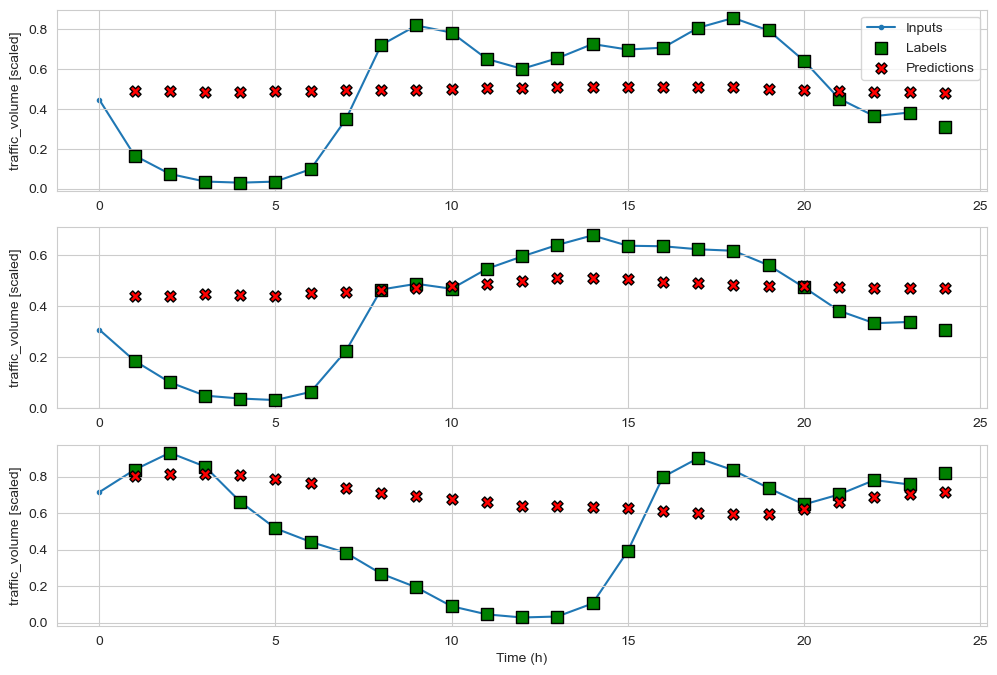

In [44]:
wide_window.plot(mo_linear)

## Implementing the deep neural network

* We add hidden layers to the neural network.
* We will also be adding a non-linear activation function to capture non-linear relationships in the data.
* A neuron is the induvidual units of the hidden layer.
* The activation function in each neuron is used for generating output from the input data.
* Here we are using ReLu as the activation function.

### Single-step deep neural network

In [46]:
dense = Sequential([
    Dense(units=64, activation='relu'), #hidden layer
    Dense(units=64, activation='relu'), #hidden layer
    Dense(units=1) #output layer

])

In [47]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/50
384/384 [==============================] - 3s 5ms/step - loss: 0.0151 - mean_absolute_error: 0.0804 - val_loss: 0.0054 - val_mean_absolute_error: 0.0538
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0049 - mean_absolute_error: 0.0515 - val_loss: 0.0035 - val_mean_absolute_error: 0.0447
Epoch 3/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0036 - mean_absolute_error: 0.0447 - val_loss: 0.0025 - val_mean_absolute_error: 0.0375
Epoch 4/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0401 - val_loss: 0.0026 - val_mean_absolute_error: 0.0387
Epoch 5/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0383 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355
Epoch 6/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0373 - val_loss: 0.0022 - val_mean_absolute_error: 0.0348
Epoch 7/50
384/3

In [48]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 1s 4ms/step - loss: 0.0021 - mean_absolute_error: 0.0323


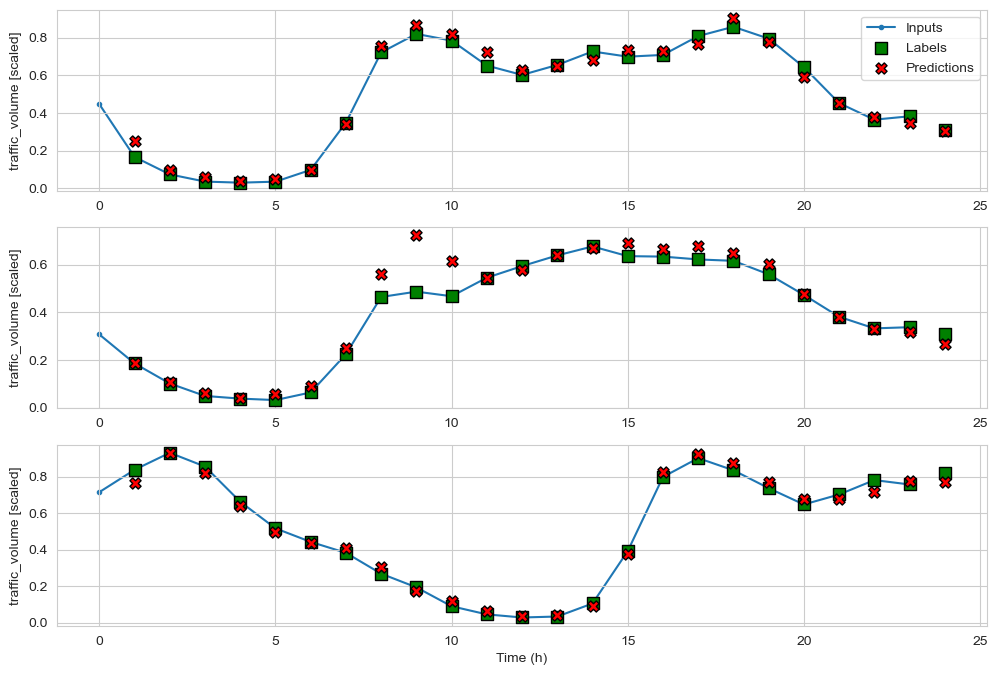

In [51]:
wide_window.plot(dense)

* As we can see the predictions are more accurate than the linear models.
* We can comapre and see the MAE of the DNN, linear and baseline models to see the results.

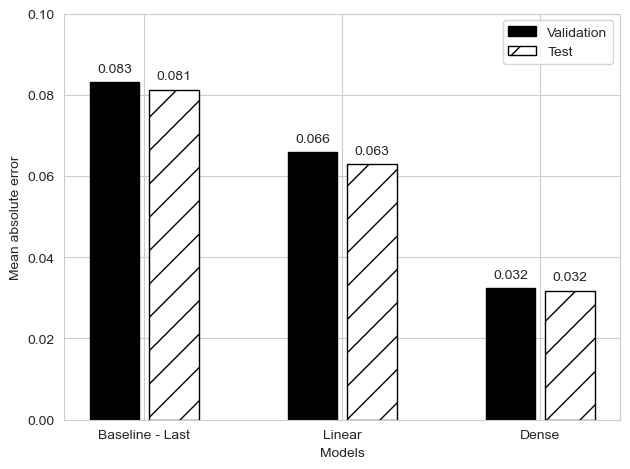

In [52]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

* As we can see that the MAE is highest for the baseline model and decrease for the linear and DNN in that order.
* So, the DNN has the best performance. 

### Multi-step deep learning model

In [53]:
ms_dense = Sequential([
    Dense(units=64, activation='relu'), #hidden layer
    Dense(units=64, activation='relu'), #hidden layer
    Dense(units=1, kernel_initializer=tf.initializers.zeros) #output layer
])

In [54]:
history = compile_and_fit(ms_dense, multi_window)

Epoch 1/50
383/383 [==============================] - 5s 8ms/step - loss: 0.0280 - mean_absolute_error: 0.1093 - val_loss: 0.0164 - val_mean_absolute_error: 0.0835
Epoch 2/50
383/383 [==============================] - 4s 10ms/step - loss: 0.0142 - mean_absolute_error: 0.0788 - val_loss: 0.0158 - val_mean_absolute_error: 0.0799
Epoch 3/50
383/383 [==============================] - 4s 9ms/step - loss: 0.0135 - mean_absolute_error: 0.0769 - val_loss: 0.0151 - val_mean_absolute_error: 0.0845
Epoch 4/50
383/383 [==============================] - 5s 12ms/step - loss: 0.0132 - mean_absolute_error: 0.0769 - val_loss: 0.0147 - val_mean_absolute_error: 0.0844
Epoch 5/50
383/383 [==============================] - 4s 10ms/step - loss: 0.0129 - mean_absolute_error: 0.0762 - val_loss: 0.0146 - val_mean_absolute_error: 0.0759
Epoch 6/50
383/383 [==============================] - 4s 9ms/step - loss: 0.0127 - mean_absolute_error: 0.0756 - val_loss: 0.0145 - val_mean_absolute_error: 0.0752
Epoch 7/50
38

In [55]:
ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 4ms/step - loss: 0.0135 - mean_absolute_error: 0.0742


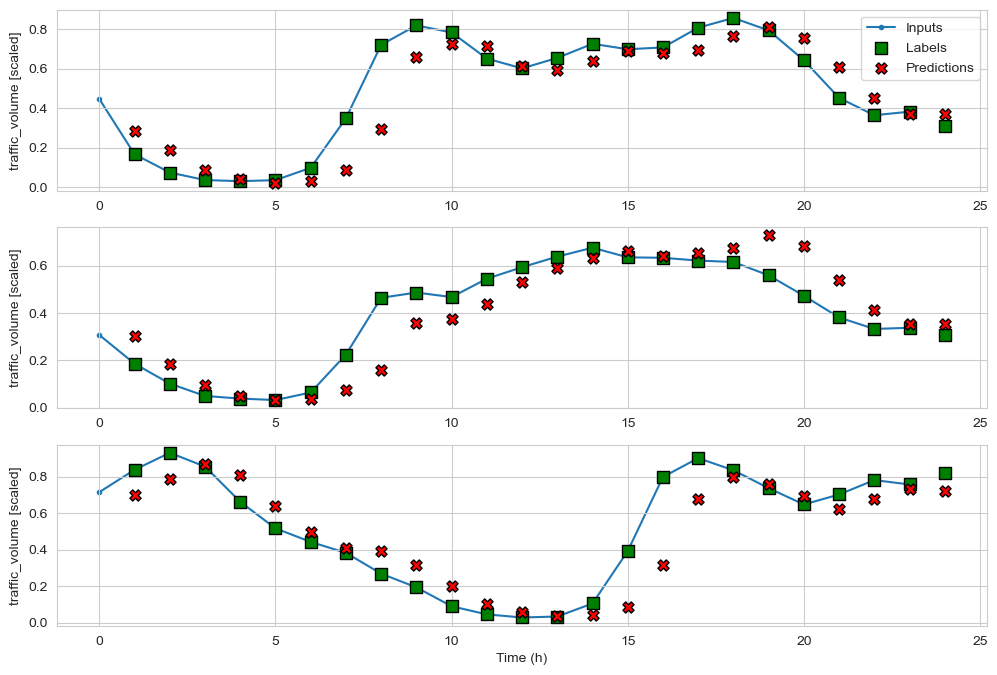

In [56]:
wide_window.plot(ms_dense)

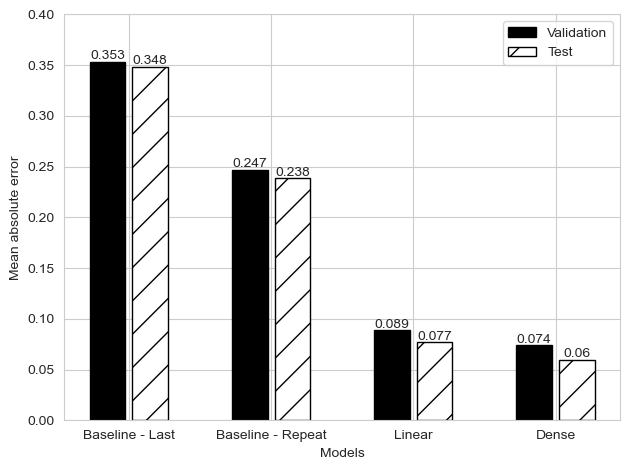

In [57]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

* Again both the linear and DNN models outperform the baseline models. 

### Multi-output deep neural network model

In [58]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

In [59]:
history = compile_and_fit(mo_dense, mo_single_step_window)

Epoch 1/50
384/384 [==============================] - 7s 11ms/step - loss: 0.0154 - mean_absolute_error: 0.0677 - val_loss: 0.0028 - val_mean_absolute_error: 0.0327
Epoch 2/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0026 - mean_absolute_error: 0.0321 - val_loss: 0.0019 - val_mean_absolute_error: 0.0286
Epoch 3/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0020 - mean_absolute_error: 0.0290 - val_loss: 0.0014 - val_mean_absolute_error: 0.0250
Epoch 4/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0271 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311
Epoch 5/50
384/384 [==============================] - 4s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0262 - val_loss: 0.0012 - val_mean_absolute_error: 0.0224
Epoch 6/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0254 - val_loss: 0.0013 - val_mean_absolute_error: 0.0245
Epoch 7/50
384/

In [60]:
mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

110/110 [==============================] - 1s 4ms/step - loss: 0.0010 - mean_absolute_error: 0.0208


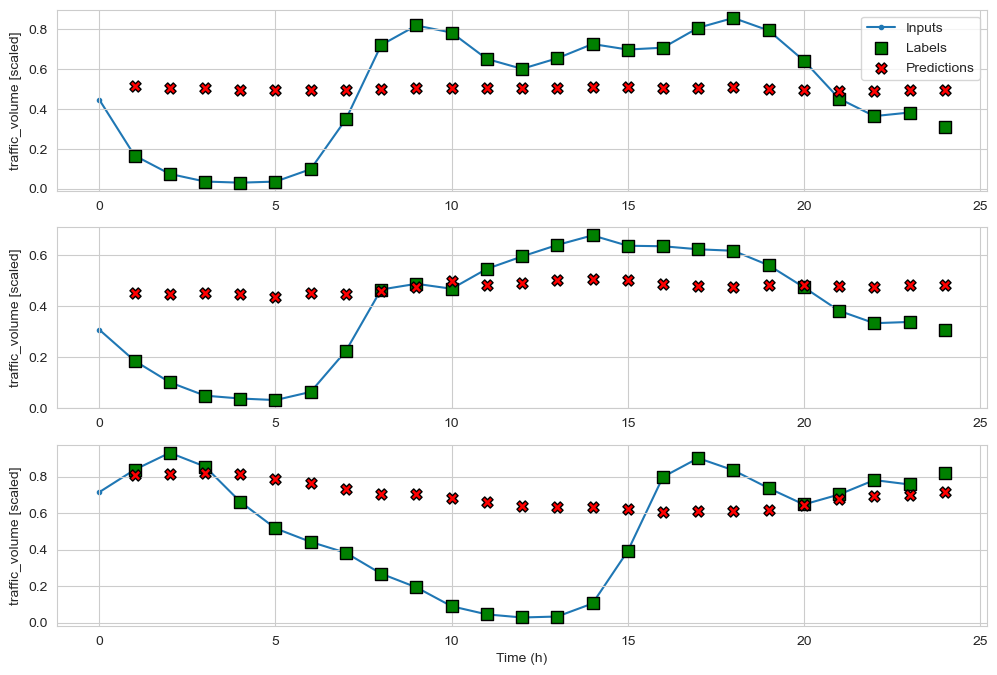

In [61]:
wide_window.plot(mo_dense)

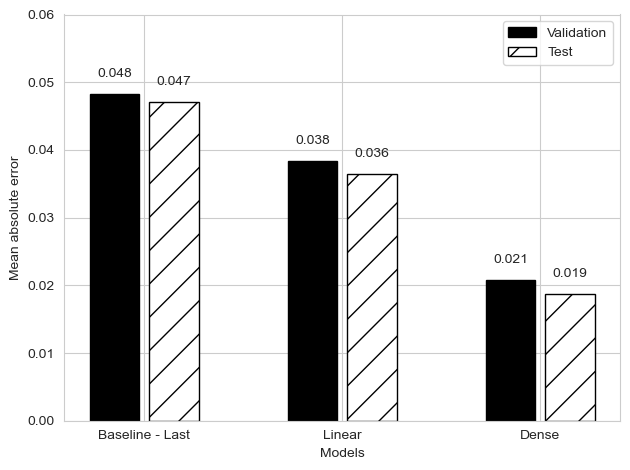

In [62]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

* Here we can see the DNN model clearly out-performing the other models.